In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

# Chemin vers le dossier contenant 'Pneumonia' et 'Normal'
data_dir = './chest_Xray/train'  # ou tout ton dataset si tu veux

# Initialiser les listes
images = []
labels = []

2025-05-14 22:47:58.178343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-14 22:47:58.464691: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from PIL import UnidentifiedImageError

for label in ['PNEUMONIA', 'NORMAL']:
    path = os.path.join(data_dir, label)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = load_img(img_path, target_size=(150, 150))
            img = img_to_array(img) / 255.0  # Normalisation entre 0 et 1
            images.append(img)
            labels.append(1 if label == 'PNEUMONIA' else 0)
        except UnidentifiedImageError:
            print(f"Fichier non valide ignoré : {img_path}")


# Transformer en tableau numpy
images = np.array(images)
labels = np.array(labels)

Fichier non valide ignoré : ./chest_Xray/train/PNEUMONIA/.DS_Store
Fichier non valide ignoré : ./chest_Xray/train/NORMAL/.DS_Store


In [3]:
# Split classique
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Train : {X_train.shape}, Test : {X_test.shape}")

Train : (4172, 150, 150, 3), Test : (1044, 150, 150, 3)


In [4]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 5. Entraîner le modèle
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

2025-05-14 22:49:02.078962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
131/131 [==============================] - 37s 270ms/step - loss: 0.2721 - accuracy: 0.8809 - val_loss: 0.1299 - val_accuracy: 0.9569
Epoch 2/5
131/131 [==============================] - 37s 281ms/step - loss: 0.1091 - accuracy: 0.9590 - val_loss: 0.1006 - val_accuracy: 0.9693
Epoch 3/5
131/131 [==============================] - 36s 275ms/step - loss: 0.0839 - accuracy: 0.9703 - val_loss: 0.0775 - val_accuracy: 0.9741
Epoch 4/5
131/131 [==============================] - 36s 278ms/step - loss: 0.0691 - accuracy: 0.9753 - val_loss: 0.1075 - val_accuracy: 0.9646
Epoch 5/5
131/131 [==============================] - 37s 281ms/step - loss: 0.0613 - accuracy: 0.9760 - val_loss: 0.0855 - val_accuracy: 0.9761


In [5]:
# Prédire
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype("int32")

# Calculer les métriques
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predicted_classes)
print("Matrice de confusion :\n", cm)

TN, FP, FN, TP = cm.ravel()

sensitivity = TP / (TP + FN)
precision = TP / (TP + FP)
specificity = TN / (TN + FP)

print(f"Sensitivity (Recall): {sensitivity:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Specificity: {specificity:.2f}")


33/33 [==============================] - 4s 120ms/step
Matrice de confusion :
 [[253  15]
 [ 10 766]]
Sensitivity (Recall): 0.99
Precision: 0.98
Specificity: 0.94


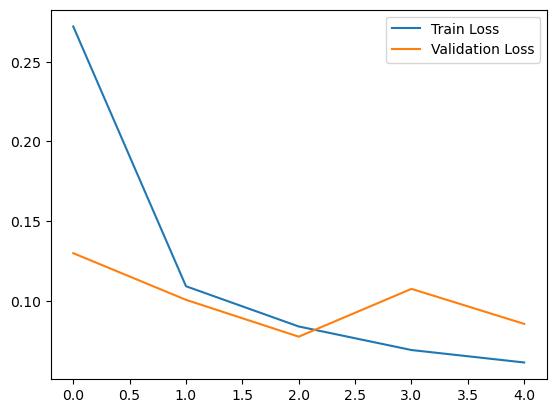

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
import os
import tensorflow as tf
import tf2onnx
import onnx
import numpy as np


def export_keras_to_onnx(model, sample_input, file_path="model.onnx"):
    """
    Exporte un modèle Keras vers ONNX
    
    Parameters:
    model: Modèle Keras compilé et entraîné
    sample_input: Exemple d'entrée (un petit échantillon de X_test)
    file_path: Chemin où sauvegarder le fichier ONNX
    """

    input_shape = model.input_shape[1:]
    
    spec = (tf.TensorSpec((None, *input_shape), tf.float32, name="input"),)
    
    model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=12)
    
    onnx.save(model_proto, file_path)
    print(f"Modèle exporté avec succès vers {file_path}")
     
    try:
        onnx_model = onnx.load(file_path)
        onnx.checker.check_model(onnx_model)
        print("Le modèle ONNX a été vérifié et est valide!")
    except Exception as e:
        print(f"Erreur lors de la vérification du modèle ONNX: {e}")

#Créer le chemin complet avec le répertoire actuel
current_dir = os.getcwd()
output_path = os.path.join(current_dir, "pneumonia_model.onnx")

if 'X_test' not in globals():
    sample_input = np.zeros((1, 150, 150, 3), dtype=np.float32)  
else:
    sample_input = X_test[:1] 

#Exportation du modèle
export_keras_to_onnx(model, sample_input, output_path)

2025-05-14 22:52:13.529012: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-05-14 22:52:13.529771: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-14 22:52:14.310480: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-05-14 22:52:14.310641: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


Modèle exporté avec succès vers /home/adk/Documents/Machine_Learning/pneumonia_model.onnx
Le modèle ONNX a été vérifié et est valide!
